Dependency links:
- [rdflib](https://github.com/RDFLib/rdflib)
- [imdbpie](https://github.com/richardasaurus/imdb-pie)
- [pandas](http://pandas.pydata.org/)
- [matplotlib](https://matplotlib.org/)
- [numpy](https://www.numpy.org/)
- [unidecode](https://pypi.python.org/pypi/Unidecode)

In [1]:
# # This step takes a while

# import rdflib

# g = rdflib.Graph()
# g.parse("film_data.nt", format="nt")

# len(g)

In [2]:
# import re

# film_trope_dict = {}


# for t_sub, t_obj in g.subject_objects(predicate=rdflib.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type')):
#     title = ''
#     trope = ''
#     try:
#         title = re.match('http://dbtropes.org/resource/Film/([^/]*)', t_sub).groups()[0]
#         trope = re.match('http://dbtropes.org/resource/Main/([^/]*)', t_obj).groups()[0]
#         if title in film_trope_dict:
#             film_trope_dict[title].append(trope)
#         else:
#             film_trope_dict[title] = [trope]
#     except Exception:
#         pass


In [3]:
# save / load film_trope_dict.pkl so that parsing with rdflib can be skipped if just playing with data visualization


import re # TODO: comment this line out if not starting from pickle 

import pickle

## write python dict to a file

# output = open('film_trope_dict.pkl', 'wb')
# pickle.dump(film_trope_dict, output)
# output.close()

# read python dict back from the file
pkl_file = open('film_trope_dict.pkl', 'rb')
film_trope_dict = pickle.load(pkl_file)
pkl_file.close()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Make a DataFrame of all film-trope pairs with an arbituary index
    
film_trope_df = pd.DataFrame.from_dict(film_trope_dict, orient ="index").sort_index().stack().reset_index(level=1, drop=True).reset_index()    
film_trope_df.columns = ['title', 'trope']
film_trope_df.head()

,title,trope
0,ABeautifulMind,ScienceRelatedMemeticDisorder
1,ABeautifulMind,HollywoodNerd
2,ABeautifulMind,TheBigBoard
3,ABeautifulMind,MadMathematician
4,ABeautifulMind,EEqualsMCHammer


In [5]:
# Funtion to add spaces between words, in order to display tropes better

def add_space(text):
    return re.sub(r"\B([A-Z]+)", r" \1", text)

film_trope_df['trope'] = film_trope_df['trope'].map(add_space, na_action='ignore')

In [6]:
# Counting the frequency of each trope

total_counts = pd.DataFrame(film_trope_df['trope'].value_counts()).reset_index()
total_counts.columns = ['trope', 'counts']

In [7]:
# # Function to plot the distribution of the count frequency.
# # ax: where to plot
# # df: sorted DataFrame of frequencies, with an autoincrement index
# # col_data: name of the column that contains the counts
# # title, xlabel, ylabel: figure labels

# def plot_counts_dist(ax, df, col_data, title, xlabel='Trope Rank (within group)', ylabel='Trope Frequency (%)'):
#     counts_sum = df[col_data].sum()
    
    
#     ax.fill_between(x = df.index, y1 = df[col_data] / counts_sum * 100, y2 = 0, color = 'b', alpha = 0.5)

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.yaxis.set_ticks_position('left')
#     ax.xaxis.set_ticks_position('bottom')

#     ax.set_xlim(0, len(df))
#     ax.set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]) * len(df))

#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.set_title(title)


# fig, ax = plt.subplots()
# plot_counts_dist(ax, total_counts, 'counts', title = 'Distribution of Trope Frequencies \nAmong All Films in DBtropes')

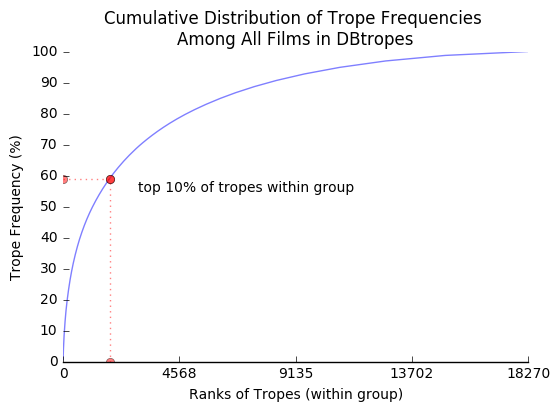

In [8]:
# Function to plot the cumulative distribution of the count frequency.
# ax: where to plot
# df: sorted DataFrame of frequencies, with an autoincrement index
# col_data: name of the column that contains the counts
# title, xlabel, ylabel: figure labels

def plot_counts_cumsum(ax, df, col_data, title, xlabel='Ranks of Tropes (within group)', ylabel='Trope Frequency (%)'):
    counts_sum = df[col_data].sum()
    cumsum_df = df[col_data].cumsum() / counts_sum * 100
    
    ax.plot(cumsum_df, color = 'b', alpha = 0.5)
    
    # add lines at 10% total trope population
    px = round(0.1 * len(cumsum_df))
    py = cumsum_df.loc[px]
    ax.plot([px, px], [0, py], 'r:', marker = 'o', alpha = 0.5)
    ax.plot([0, px], [py, py], 'r:', marker = 'o', alpha = 0.5)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.set_xlim(0, len(df))
    ax.set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]) * len(df))
    ax.set_yticks(np.arange(0, 110, 10))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


fig, ax = plt.subplots()
plot_counts_cumsum(ax, total_counts, 'counts', title = 'Cumulative Distribution of Trope Frequencies \nAmong All Films in DBtropes')
fig.text(0.25, 0.55, 'top 10% of tropes within group')

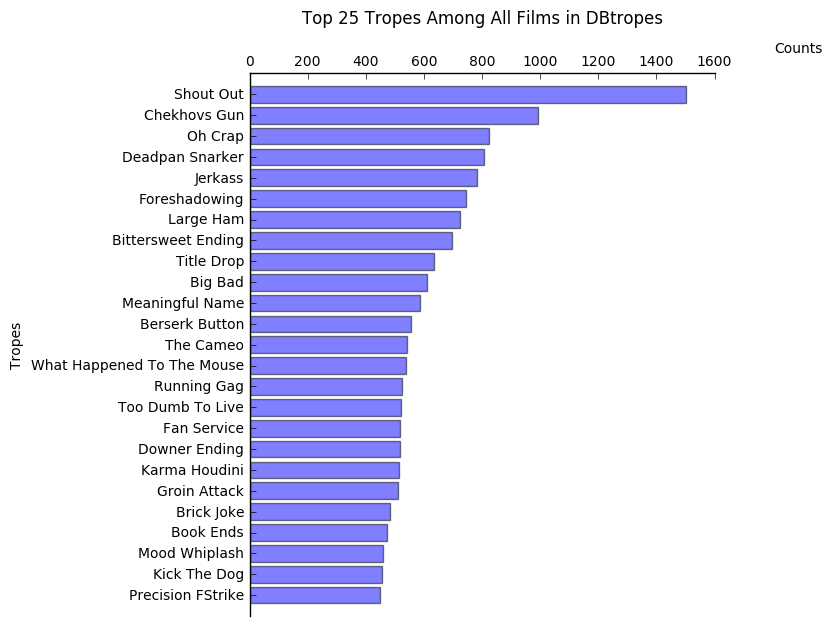

In [9]:
# Function to plot a 'histogram' of top frequencies
# ax: where to plot the figure
# df: sorted DataFrame of frequencies, with an autoincrement index
# col_label: name of the column that contains the trope labels 
# col_data: name of the column that contains the counts
# n: number of tropes to be shown, default 25
# title, xlabel, ylabel: figure labels
# color, alpha: bar appearance, default color = blue, alpha = 0.5
# flip_x: flip x axis, default False

def plot_counts(ax, df, col_label, col_data, title, xlabel='Counts', ylabel='Tropes', 
                color='blue', alpha=0.5, n=25, flip_x=False):
    new = df.head(n)
        
    ax.barh(new.index, new[col_data], color=color, alpha=alpha, align='center')
    ax.set_yticks(np.arange(len(new[col_label])))
    ax.set_yticklabels(new[col_label])
    ax.set_ylim(-1, len(new[col_label]))
    ax.invert_yaxis()

    if flip_x:
        ax.invert_xaxis()
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.xaxis.set_ticks_position('top')
    else:
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('top')
    
    ax.set_xlabel(xlabel)
    ax.xaxis.set_label_coords(1.18, 1.06)
    ax.set_ylabel(ylabel)
    ax.set_title(title, y = 1.08)

fig, ax = plt.subplots(figsize=(6, 7))
plot_counts(ax, total_counts, 'trope', 'counts', title='Top 25 Tropes Among All Films in DBtropes')

In [10]:
from imdbpie import Imdb

# Initiate imdb
imdb = Imdb()
imdb = Imdb(anonymize=True) # to proxy requests

In [11]:
top_movies = imdb.top_250()
top_250 = pd.DataFrame([movie['title'] for movie in top_movies], columns = ['imdb_title'])             

In [12]:
# Function to strip spaces, capitalization, punctuation and accents from stitles.

import unidecode
def strip_lowercase(text):
    text = unidecode.unidecode(text) # dependency: unidecode
    return re.sub(r'[^\w]', '', text).lower()

film_trope_df['strip_title'] = film_trope_df['title'].map(strip_lowercase, na_action='ignore')
top_250['strip_title'] = top_250['imdb_title'].map(strip_lowercase, na_action='ignore')

top_250['isin_dbtrope'] = top_250['strip_title'].isin(film_trope_df['strip_title'])
film_trope_df['is_top250'] = film_trope_df['strip_title'].isin(top_250['strip_title'])

In [13]:
len(film_trope_df[film_trope_df['is_top250'] == True]['title'].unique())
# TODO: this means there are some unfortunate mis-naming happening. Need more cleaning.
# Also some films in the top 250 do not have any trope instances, eg. Nausicaä of the Valley of the Wind

165

In [14]:
# Counting tropes for movies that are in the top 250
top_counts = pd.DataFrame(film_trope_df[film_trope_df['is_top250'] == True]['trope'].value_counts()).reset_index()
top_counts.columns = ['trope', 'counts']

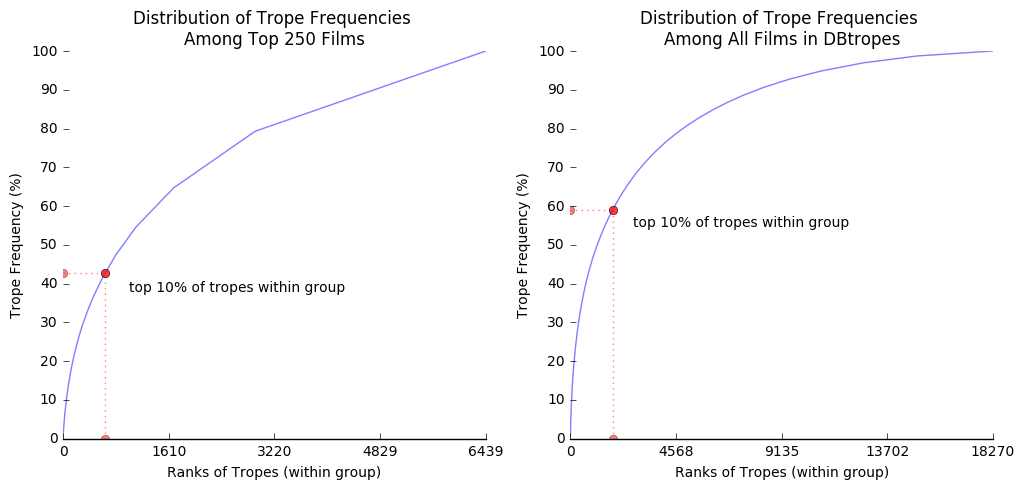

In [15]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5)) 
plt.setp(ax[1].get_yticklabels(), visible=True)
plot_counts_cumsum(ax[0], top_counts, 'counts', title='Distribution of Trope Frequencies \nAmong Top 250 Films') 
plot_counts_cumsum(ax[1], total_counts, 'counts', title='Distribution of Trope Frequencies \nAmong All Films in DBtropes')    

fig.text(0.18, 0.42, 'top 10% of tropes within group')
fig.text(0.6, 0.55, 'top 10% of tropes within group')
#plt.savefig('cum_distribution.png')

In [16]:
# Summarize counts in both samples in a DataFrame combined_df
combined_df = top_counts.merge(total_counts, left_on='trope', right_on='trope', how='outer')
combined_df.fillna(0, inplace=True)
combined_df.columns = ['trope', 'top_counts', 'all_counts']
# Convert raw counts into percentages (%).
combined_df['top_counts_pct'] = combined_df['top_counts'] / top_counts['counts'].sum() * 100
combined_df['all_counts_pct'] = combined_df['all_counts'] / total_counts['counts'].sum() * 100
combined_df['top_minus_all'] = combined_df['top_counts_pct'] - combined_df['all_counts_pct']
# Find out whether all_counts_pct >, ==, or < top_250_count_pct 
# Values would be 1, 0, -1 in column 'all_VS_top, respectively
combined_df.loc[combined_df['top_minus_all'] > 0, 'top_VS_all'] = 1
combined_df.loc[combined_df['top_minus_all'] == 0, 'top_VS_all'] = 0
combined_df.loc[combined_df['top_minus_all'] < 0, 'top_VS_all'] = -1
# Generate a Series of colors to indicate 'all_VS_top' values
color_dict = {1: 'teal', 0: '#8D6868', -1: 'red'}
combined_df['colors'] = combined_df['top_VS_all'].map(color_dict)

combined_df.head()

,trope,top_counts,all_counts,top_counts_pct,all_counts_pct,top_minus_all,top_VS_all,colors
0,Shout Out,73.0,1502,0.430399,0.583643,-0.153244,-1.0,red
1,Oh Crap,66.0,823,0.389128,0.319799,0.069329,1.0,teal
2,Foreshadowing,61.0,746,0.359649,0.289879,0.069770,1.0,teal
3,Bittersweet Ending,61.0,697,0.359649,0.270838,0.088810,1.0,teal
4,Deadpan Snarker,49.0,805,0.288898,0.312805,-0.023907,-1.0,red


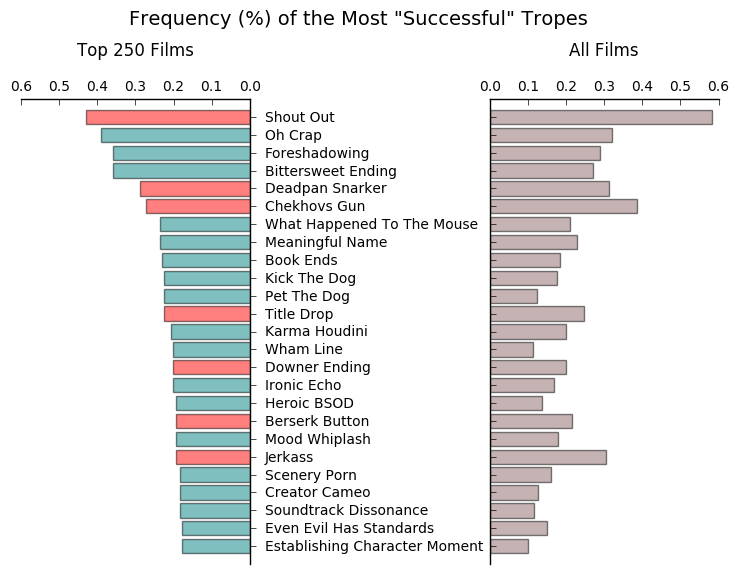

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(9, 6)) 
plt.setp(axes[1].get_yticklabels(), visible=True)

# butterfly graph
n = 25
left_fig = plot_counts(axes[0], combined_df, 'trope', 'top_counts_pct', color=combined_df['colors'],
                       xlabel='', ylabel='',
                       title='Top 250 Films', n=n, flip_x=True)

right_fig = plot_counts(axes[1], combined_df, 'trope', 'all_counts_pct', color='#8D6868',
                        xlabel='', ylabel='',
                        title='All Films', n=n)

axes[0].tick_params(axis='y', direction='out', pad=7)
n_lim = 0.6
axes[0].set_xlim(n_lim, 0)
axes[0].set_xticks(np.arange(0, n_lim + 0.1, 0.1))
axes[1].set_xlim(0, n_lim)
axes[1].set_xticks(np.arange(0, n_lim + 0.1, 0.1))

labels = [item.get_text() for item in axes[1].get_yticklabels()]
empty_string_labels = ['']*len(labels)
axes[1].set_yticklabels(empty_string_labels)

my_suptitle=plt.suptitle('Frequency (%) of the Most "Successful" Tropes', y=1.05, fontsize=14)

plt.subplots_adjust(wspace = 1.05)

fig.savefig('most_popular_tropes_top_films.png', dpi=150, bbox_inches='tight', bbox_extra_artists=[my_suptitle])

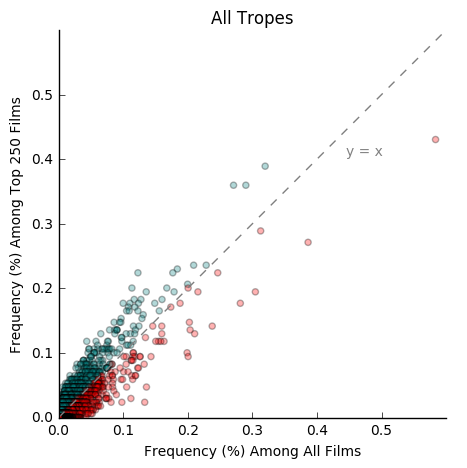

In [18]:
# Scatter plot of tropes. Position of each dot / trope is its (combined_df.all_counts_pct, combined_df.top_counts_pct).
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x=combined_df['all_counts_pct'], y=combined_df['top_counts_pct'], 
          c=combined_df['colors'], alpha=0.3, linewidth=1)
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 0.6)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", color='gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Frequency (%) Among All Films')
ax.set_ylabel('Frequency (%) Among Top 250 Films')
ax.set_title('All Tropes')

fig.text(0.7, 0.65, 'y = x', color='gray')
plt.savefig('trope_scatter.png', dpi=150, bbox_inches='tight')